# SM EWPT with Varied Parameters

In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate
from scipy import integrate
from scipy import optimize
from cosmoTransitions import generic_potential as gp
from cosmoTransitions import tunneling1D as td
from matplotlib import pyplot as plt
from finiteT import Jb_spline as Jb
from finiteT import Jf_spline as Jf
from cosmoTransitions import pathDeformation as pd

In [2]:
v = 246.22
mt = 120.0

In [3]:
def df(f, x, eps):
    """
    Calculate the derivative of a function to the second order,
    using the Ridders algorithm.
    f: callable. The function to be calculated.
    x: the point to calculate.
    eps: the step.
    """
    return (f(x-2*eps) - 8*f(x-eps) + 8*f(x+eps) - f(x+2*eps)
            ) / (12.*eps)

def d2f(f, x, eps):
    """
    Calculate the 2nd-order derivative of a function to the second order,
    using the Ridders algorithm.
    f: callable. The function to be calculated.
    x: the point to calculate.
    eps: the step.
    """
    return (-f(x-2*eps) + 16*f(x-eps) - 30*f(x)
                + 16*f(x+eps) - f(x+2*eps)) / (12.*eps*eps)

In [4]:
class SM(gp.generic_potential):
    def init(self, g2, λ, μhsq,Teps=0.02):
        self.Ndim = 1
        self.g2 = g2
        self.g1 = 0.358
        self.λ = λ
        self.μh = μhsq**0.5
        self.yt = 2**0.5 * mt / v
        self.Tmax = 200
        self.Tmin = 20
        self.Tc = None
        self.Tn = None
        self.Tcvev = None
        self.Tnvev = None
        self.strengthTc = None
        self.strengthTn = None
        self.βH = None
        self.α = None
        self.renormScaleSq = 1e4
        self.Teps = Teps

    def V0(self, X):
        X = np.array(X)
        h = X[..., 0]
        return -0.5 * self.μh**2 * h**2 + 0.25 * self.λ * h**4

    def boson_massSq(self, X, T):
        X = np.array(X)
        h = X[..., 0]
        T2 = T * T
        mgs = (
            self.λ * h**2
            - self.λ * v**2
            + (
                3 * self.g2**2 / 16
                + self.g1**2 / 16
                + 0.5 * self.λ
                + 0.25 * self.yt**2
            )
            * T2
        )
        mhsq = (
            3*self.λ * h**2
            - self.λ * v**2
            + (
                3 * self.g2**2 / 16
                + self.g1**2 / 16
                + 0.5 * self.λ
                + 0.25 * self.yt**2
            )
            * T2
        )

        mW = 0.25 * self.g2**2 * h**2
        mWL = mW + 11 * self.g2**2 * T2 / 6
        mZ = 0.25 * (self.g2**2 + self.g1**2) * h**2

        AZsq = np.sqrt(
            (self.g2**2 + self.g1**2) ** 2 * (3 * h**2 + 22 * T2) ** 2
            - 176 * self.g2**2 * self.g1**2 * T2 * (3 * h**2 + 11 * T2)
        )

        mZL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) + AZsq) / 24
        mAL = ((self.g2**2 + self.g1**2) * (3 * h**2 + 22 * T2) - AZsq) / 24

        M = np.array([mgs,mhsq,mW,mWL,mZ,mZL,mAL])
        M = np.rollaxis(M,0,len(M.shape))

        dof = np.array([3,1,4,2,2,1,1])
        c = np.array([1.5,1.5,0.5,1.5,0.5,1.5,1.5])

        return M.real + 1e-16, dof, c
    
    def fermion_massSq(self, X):
        X = np.array(X)
        h = X[...,0]
        
        mtt = 0.5 * self.yt**2 * h**2
        Mf = np.array([mtt])
        Mf = np.rollaxis(Mf, 0, len(Mf.shape))

        doff = np.array([12.0])
        return Mf, doff
    
    def V1(self, bosons, fermions):
        """
        Method of CosmoTransitions. Overwritten.

        The 1-loop CW correction at the zero-temperature in the
        MS-bar renormalization scheme.
        """
        Q2 = self.renormScaleSq
        m2, n, c = bosons
        y = np.sum(n * m2 * m2 * (np.log(m2 / Q2 + 1e-100 + 0j) - c), axis=-1)
        m2, n = fermions
        c = 1.5
        y -= np.sum(n * m2 * m2 * (np.log(m2 / Q2 + 1e-100 + 0j) - c), axis=-1)
        return y.real / (64 * np.pi * np.pi)
    
    def V0T(self, X):
        """
        1-loop corrected effective potential at T=0.
        Not an intrinsic method of CosmoTransitions.
        """
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X, 0)
        fermions = self.fermion_massSq(X)

        y = self.V0(X)
        y += self.V1(bosons, fermions)

        return y

    def V1T(self, bosons, fermions, T, include_radiation=True):
        """
        Method of CosmoTransitions. Should be overwritten.
        The 1-loop finite-temperature correction term.

        `Jf` and `Jb` are modified functions.

        TODO: understand this again, write note, and implement it.
        """

        T2 = (T * T) + 1e-100
        T4 = T2 * T2

        m2, nb, _ = bosons
        y = np.sum(nb * Jb(m2 / T2), axis=-1)
        m2, nf = fermions
        y += np.sum(nf * Jf(m2 / T2), axis=-1)

        return y * T4 / (2 * np.pi * np.pi)

    def Vtot(self, X, T, include_radiation=True):
        """
        Method of CosmoTransitions.
        The total finite temperature effective potential.
        """

        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)

        bosons = self.boson_massSq(X, T)
        fermions = self.fermion_massSq(X)
        Vtot = self.V0(X)
        Vtot += self.V1(bosons, fermions)
        Vtot += self.V1T(bosons, fermions, T, include_radiation)

        return Vtot
    
    def Plot(self,xminmax,npoints=500,T=0):
        xmin = xminmax[0]
        xmax = xminmax[1]
        hspace=np.linspace(xmin,xmax,npoints)
        H = hspace[:,np.newaxis]
        if T==0:
            Vspace=self.V0T(H)
        else:
            Vspace=self.Vtot(H,T)
        plt.plot(hspace, Vspace)
        plt.show()

    
    def findTc(self):
        num_i = 30
        Tmax = self.Tmax
        Tmin = self.Tmin
        T_test = (Tmax + Tmin) * 0.5
        print("Finding Tc...")
        for i in range(num_i + 10):
            min = optimize.fmin(self.Vtot,100,args=(T_test,),disp=False,full_output=1)
            xmin = min[0]
            ymin = min[1]
            if ymin < self.Vtot([1e-16], T_test) and xmin > 1:
                if i > num_i:
                    self.Tc = T_test
                    self.Tcvev = xmin[0]
                    self.strengthTc = xmin[0]/T_test
                    break
                else:
                    Tmin = T_test
                    Tnext =(Tmax + T_test) * 0.5
                    T_test = Tnext
            else:
                Tmax = T_test
                Tnext = (Tmin + T_test) * 0.5
                T_test = Tnext

        print("Critical temperature found! Tc = " + str(self.Tc))
        print("v_c/Tc = " + str(self.strengthTc))

    def tunneling_at_T(self,T):
        if self.Tc is None:
            self.findTc()
        assert T < self.Tc
        h_range = np.linspace(-2.0 * self.Tcvev, 2.0 * self.Tcvev, 1000)
        V_range = np.array([self.Vtot([h],T) for h in h_range])
        Vinter=interpolate.UnivariateSpline(h_range,V_range, s=0)
        tv=optimize.fmin(Vinter,self.Tcvev,disp=False)[0]
        gradV=Vinter.derivative()
        tv = optimize.fmin(self.Vtot,100,args=(T,),disp=False)[0]

        tobj = td.SingleFieldInstanton(tv,1e-16, Vinter, gradV)
        profile =  tobj.findProfile()
        action = tobj.findAction(profile)

        return {"profile":profile, "action":action}
    
    def findTn(self):
        if self.Tc==None:
            self.findTc()

        print("Finding Tn...")
        
        Tmax = self.Tc - self.Teps
        data = []
        for i in range(0,1000):
            Ttest = Tmax - i*self.Teps
            print("Tunneling at T = " + str(Ttest))
            ST = self.tunneling_at_T(Ttest)["action"]/Ttest
            print("S3/T = " + str(ST))
            data.append([Ttest,ST])
            if ST < 140.0:
                break
        Tmin = Ttest
        print("Tnuc should be within " + str(Tmin) + " and " + str(Tmin + self.Teps))
        data = np.array(data)
        Tdata = data[:,0]
        S3Tdata = data[:,1]
        S3Tfunc = interpolate.interp1d(Tdata,np.log10(S3Tdata),kind='cubic')
        Tn = optimize.brentq(lambda T:S3Tfunc(T) - np.log10(140.0), Tmin, Tmin+self.Teps,disp=False)
        print("Tn = " + str(Tn))
        self.Tn = Tn
        Tnvev = optimize.fmin(self.Vtot, self.Tcvev, args=(Tn,),disp=False)[0]
        self.Tnvev = Tnvev
        self.strengthTn = Tnvev/Tn
        print("v_n/Tn = " + str(self.strengthTn))

    def findβH(self):
        if self.Tn==None:
            self.findTn()
        if self.βH == None:
            eps = self.Teps/10
            T_list = [self.Tn-2*eps, self.Tn-eps, self.Tn+eps, self.Tn+2*eps]
            S3Tlist = []
            for T in T_list:
                S3Tlist.append(self.tunneling_at_T(T)["action"]/T)
            dS3T_dT = (S3Tlist[0]-8*S3Tlist[1]+8*S3Tlist[2]-S3Tlist[3])/(12*eps)
            self.βH = dS3T_dT*self.Tn
            print("β/H = " + str(self.βH))
        else:
            print("You already computed it before!")
            print("β/H = " + str(self.βH))
    
    def findα(self):
        if self.Tn==None:
            self.findTn()
        if self.α == None:
            fv = 1e-16
            def ΔV(T):
                tv = optimize.fmin(self.Vtot, self.Tcvev, args=(T,), disp=False)
                return self.Vtot([fv], T) - self.Vtot(tv, T)
            dΔV_dT = df(ΔV, self.Tn, self.Teps/10)
            ρrad = np.pi**2 * self.Tn**4 * 106.75/30
            latent = ΔV(self.Tn) - 0.25 * self.Tn * dΔV_dT
            self.α = latent/ρrad
            print("α = " + str(self.α))
        else:
            print("You already computed it before!")
            print("α = " + str(self.α))

    def forbidPhaseCrit(self, X):
        """
        forbid negative phases for both h and s
        """
        return any(np.array([X])[...,0] < -5.0)

In [5]:
m = SM(0.65,0.0145177,1012.88, Teps=0.002)

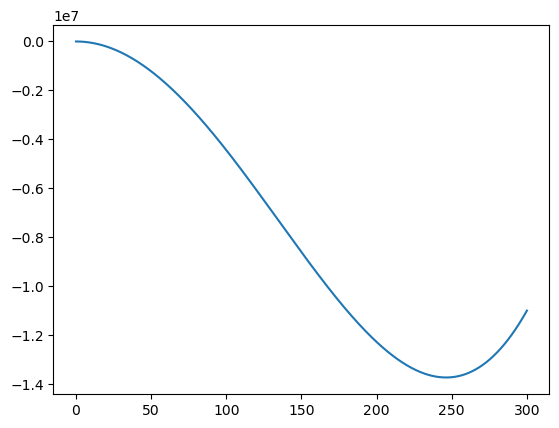

In [6]:
m.Plot((0,300),T=0)

In [7]:
m.getPhases()

Tracing phase starting at x = [246.24863777] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................................................................................................................................................................................
Tracing phase starting at x = [-6.2109375e-06] ; t = 73.85959798413047
Tracing minimum down
traceMinimum t0 = 73.8596
................................
Tracing minimum up
traceMinimum t0 = 73.8596
......


{0: Phase(key=0, X=[[246.2], ..., [54.74]], T=[0, ..., 73.66], dXdT=[[-0], ..., [-1085]],
 1: Phase(key=1, X=[[0.01917], ..., [0.001291]], T=[72.42, ..., 200], dXdT=[[-23.34], ..., [4.938e-05]]}

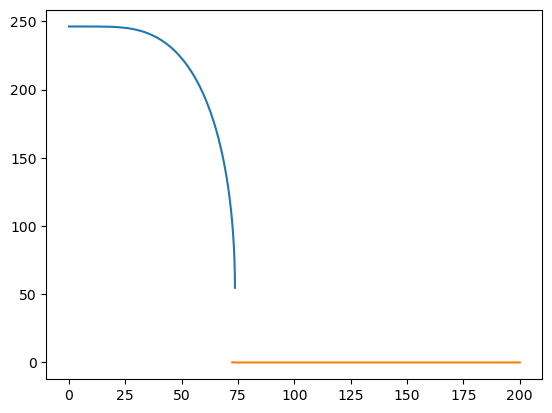

In [15]:
plt.plot(m.phases[0].T, m.phases[0].X[...,0])
plt.plot(m.phases[1].T, m.phases[1].X[...,0])

In [13]:
m.findAllTransitions()

Tracing phase starting at x = [246.24863777] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................................................................................................................................................................................
Tracing phase starting at x = [-6.2109375e-06] ; t = 73.85959798413047
Tracing minimum down
traceMinimum t0 = 73.8596
................................
Tracing minimum up
traceMinimum t0 = 73.8596
......


[]

In [16]:
m.findTc()

Finding Tc...
Critical temperature found! Tc = 73.50554961245507
v_c/Tc = 0.9729027066117977


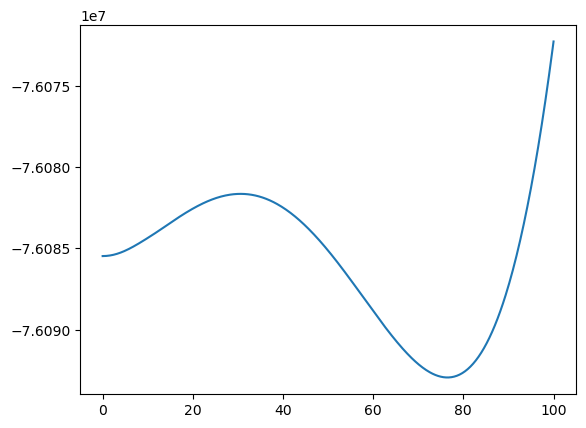

In [166]:
m.Plot((0,100),T=m.Tc-0.1)

In [274]:
m.findTn()

Finding Tn...
Tunneling at T = 73.48554961245507
S3/T = 15666.416422838336
Tunneling at T = 73.46554961245508
S3/T = 4302.575427417517
Tunneling at T = 73.44554961245507
S3/T = 2080.047657254984
Tunneling at T = 73.42554961245507
S3/T = 1261.8789675748503
Tunneling at T = 73.40554961245508
S3/T = 862.3588009385304
Tunneling at T = 73.38554961245508
S3/T = 638.3934279989793
Tunneling at T = 73.36554961245507
S3/T = 497.0059904252735
Tunneling at T = 73.34554961245507
S3/T = 403.0221220787553
Tunneling at T = 73.32554961245508
S3/T = 330.9427174409699
Tunneling at T = 73.30554961245507
S3/T = 281.8730639245607
Tunneling at T = 73.28554961245507
S3/T = 242.59496859828158
Tunneling at T = 73.26554961245508
S3/T = 210.5359633376133
Tunneling at T = 73.24554961245508
S3/T = 184.81336394693824
Tunneling at T = 73.22554961245507
S3/T = 163.65626361449435
Tunneling at T = 73.20554961245507
S3/T = 145.82041539601397
Tunneling at T = 73.18554961245508
S3/T = 131.69111059932257
Tnuc should be with

In [275]:
m.findβH()

β/H = 56668.80091133131


In [276]:
m.findα()

α = 0.001755638848776427


In [5]:
m=SM(1.05,0.00326199990813553,425.9240411562143)

In [6]:
m.findTn()

Finding Tc...
Critical temperature found! Tc = 49.37508412171155
v_c/Tc = 3.6683379822398243
Finding Tn...
Tunneling at T = 49.35508412171155
S3/T = 5120260.364695967
Tunneling at T = 49.335084121711546
S3/T = 1297822.0708112777
Tunneling at T = 49.31508412171155
S3/T = 583046.4498491186
Tunneling at T = 49.29508412171155
S3/T = 331315.3955708248
Tunneling at T = 49.27508412171155
S3/T = 214152.4105919414
Tunneling at T = 49.25508412171155
S3/T = 150170.3249403914
Tunneling at T = 49.23508412171155
S3/T = 111390.90274327768
Tunneling at T = 49.21508412171155
S3/T = 86092.82296612169
Tunneling at T = 49.19508412171155
S3/T = 68660.7552526744
Tunneling at T = 49.17508412171155
S3/T = 56129.15662028949
Tunneling at T = 49.155084121711546
S3/T = 46810.999801020844
Tunneling at T = 49.13508412171155
S3/T = 39688.64364755882
Tunneling at T = 49.11508412171155
S3/T = 34118.52716863498
Tunneling at T = 49.09508412171155
S3/T = 29677.162411636793
Tunneling at T = 49.07508412171155
S3/T = 26076.